# Exploring the commit graph

(2018-02-08)

This script crawls a repository's commit graph by inspecting files
currently in the repository and looking at all commits that have changed
that file (tracking over renames). The data is lightly processed and is
serialized to JSON to be displayed by a frontend.

In [1]:
import collections
import datetime
import json
import math
import os
import subprocess
import tempfile

import git

import matplotlib.pyplot as plt

In [2]:
class RepoContext:

  def __init__(self, repo_root):
    self._repo_root = repo_root
    
  def _tempfile_name(self):
    """Get a persistent tempfile name keyed against this repo."""
    # Encode the path to the repo in a format that can be used in paths.
    sanitized_repo_name = self._repo_root.replace(os.sep, '%')
    filename = 'file_to_hashes_%s.json' % sanitized_repo_name
    return os.path.join(tempfile.gettempdir(), filename)

  def _git_cmd(self, args):
    """Run git(1) with the specified arguments; return its stdout."""
    return subprocess.check_output(['git', '-C', self._repo_root] + args)

  def hashes_for_file(self, current_filename):
    assert current_filename, current_filename
    # Obviously really inefficient to spawn a suprocess for each file
    # in the repo, but the `git` module doesn't seem to have an easy way
    # to `--follow`... if productionized, this could just use libgit2
    # bindings for performance.
    hashes = (
        self._git_cmd(['log', '--pretty=%H', '--follow', current_filename])
    ).splitlines()
    return [h.decode('ascii') for h in hashes]

  def all_files(self):
    """Get a list of all paths to files in the git repo.
    
    Assumes that filenames are UTF-8--encoded, which seems reasonable.
    Alternately, could return a list of `bytes` objects.
    """
    file_bytestring_names = self._git_cmd([
        'ls-tree', '-r', '--full-tree', '--name-only', '-z', 'HEAD'
    ]).split(b'\0')[:-1]  # strip trailing '\0'
    return [fn.decode('utf-8') for fn in file_bytestring_names]

  def load_commit_data(self):
    """Load data about the relationships between commits and files.

    A commit is _file-reachable_ if it touches a file that currently
    exists in the repository, even if that file might have been renamed
    (but not if it has been deleted).

    Returns a dictionary `r` such that
      - `r['file_to_commits']` is a dictionary `d` such that if `f` is a
        path to a file currently tracked in the repository, then `d[f]`
        is the list of commit SHAs for all commits that have touched `f`
        (tracking across renames of `f`);
      - `r['files']` is a list of all files currently in the repository
        (and is the keyset of `r['file_to_commits']`;
      - `r['hashes']` is a list of hashes of all file-reachable commits
        (and is the union of the values of `r['file_to_commits']`;
      - `r['commits']` is a dictionary `d` such that if `h` is the hash
        of a file-reachable commit, then `d[h]` is a gitpython `Commit`
        descriptor for the commit with hash `h`; and
      - `r['repo']` is a gitpython `Repo` object for the repository.
    """
    print('Starting: %s' % self._repo_root)
    all_files = self.all_files()
    print('Got %s files' % len(all_files))

    repo = git.Repo(self._repo_root)
    head = repo.commit().hexsha

    # `files[x] = cs` where `cs` is the list of hashes that touched the
    # file now known as `x`
    try:
      print('Loading file database')
      with open(self._tempfile_name()) as infile:
        result = json.load(infile)
        assert result['base'] == self._repo_root, (
            'Cache for wrong repo: expected %r, got %r' %
            (self._repo_root, result['base']))
        assert result['head'] == head, (
            'Cache for wrong HEAD commit: expected %r, got %r'
            % (head, result['head']))
        files = result['files']
      print('Loaded file database')
    except (OSError, json.decoder.JSONDecodeError):
      # Build the cache
      print('Compiling file database')
      files = {fn: self.hashes_for_file(fn) for fn in all_files}
      print('Compiled file database')
      cache = {
          'base': self._repo_root,
          'head': head,
          'files': files,
      }
      print('Created cache for file database')
      with open(self._tempfile_name(), 'w') as outfile:
        json.dump(cache, outfile)
        print('Dumped cache for file database')

    all_hashes = frozenset().union(*files.values())
    print('Got %s hashes' % len(all_hashes))

    # `commits[h] == c` s.t. `c.hash == h`
    commits = {h: repo.commit(h) for h in all_hashes}
    print('Got %s commits' % len(commits))
    
    return {
        'file_to_commits': files,
        'hashes': all_hashes,
        'files': all_files,
        'commits': commits,
        'repo': repo,
    }

In [3]:
data = RepoContext('/home/dandelion/git/tensorboard').load_commit_data()

Starting: /home/dandelion/git/tensorboard
Got 698 files
Loading file database
Loaded file database
Got 1323 hashes
Got 1323 commits


In [4]:
# Which commits are important?
def _commit_weight(commit):
    return math.log1p(commit.stats.total['lines'])

commit_weights = {
    h: _commit_weight(data['commits'][h]) for h in data['commits']
}
weight_values = sorted(commit_weights.values())

(array([  1.,  31.,   0., 122.,  59.,  84.,  79.,  82.,  85.,  78.,  71.,
         84.,  63.,  61., 118.,  71.,  71.,  55.,  39.,  16.,  11.,   6.,
         13.,   5.,   9.,   1.,   2.,   1.,   2.,   3.]),
 array([ 0.        ,  0.35119409,  0.70238817,  1.05358226,  1.40477635,
         1.75597043,  2.10716452,  2.45835861,  2.80955269,  3.16074678,
         3.51194086,  3.86313495,  4.21432904,  4.56552312,  4.91671721,
         5.2679113 ,  5.61910538,  5.97029947,  6.32149356,  6.67268764,
         7.02388173,  7.37507582,  7.7262699 ,  8.07746399,  8.42865807,
         8.77985216,  9.13104625,  9.48224033,  9.83343442, 10.18462851,
        10.53582259]),
 <a list of 30 Patch objects>)

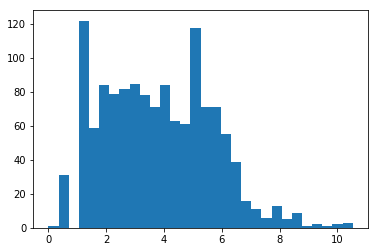

In [5]:
# Sanity check...
plt.hist(commit_weights.values(), bins=30)

In [6]:
# Which users are important?
user_weights = collections.defaultdict(lambda: 0.0)
email_resolutions = {
    'danmane@gmail.com': 'dandelion@google.com',
}
for h in data['commits']:
    nominal_email = data['commits'][h].author.email
    email = email_resolutions.get(nominal_email, nominal_email)
    user_weights[email] += commit_weights[h]

(array([104.,   5.,   2.,   1.,   1.,   1.,   1.,   1.,   2.,   2.]),
 array([  0.69314718,  57.62184883, 114.55055049, 171.47925214,
        228.4079538 , 285.33665545, 342.2653571 , 399.19405876,
        456.12276041, 513.05146206, 569.98016372]),
 <a list of 10 Patch objects>)

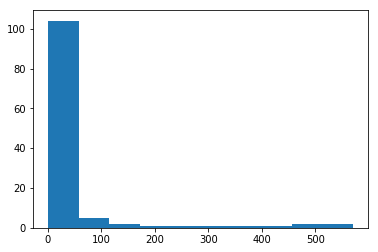

In [7]:
# Sanity check...
plt.hist(user_weights.values())

In [8]:
# Accuracy check, given that the operator is familiar with the repo...
[(k, user_weights[k]) for k in sorted(user_weights, key=user_weights.get, reverse=True)][:10]

[('dandelion@google.com', 569.9801637172158),
 ('jart@google.com', 545.0875820097374),
 ('zeng.chi@gmail.com', 474.4941786809108),
 ('gardener@tensorflow.org', 472.63110233817844),
 ('smilkov@google.com', 434.80813797887964),
 ('wchargin@gmail.com', 393.3191133762563),
 ('nicholsonc@google.com', 335.9915566820012),
 ('nsthorat@google.com', 233.81765373473377),
 ('nobody@tensorflow.org', 202.53648716913858),
 ('dsmilkov@gmail.com', 131.64270699045093)]

In [9]:
# Build a JSON object to send to the frontend.
results = {
    "fileToCommits": data['file_to_commits'],
    "commits": {
        c.hexsha: {
            "author": c.author.email,
            "stats": c.stats.files,
        }
        for c in data['commits'].values()
    },
}

In [10]:
with open('/tmp/data.json', 'w') as outfile:
    json.dump(results, outfile)